In [23]:
def check_float(textin):
    try:
        float(textin)
        return True

    except ValueError:
        return False

def check_force(folder):
    import os
    import numpy as np
    files = os.listdir(folder)
    cleaned = [float(x) for x in files if check_float(x)]
    print(np.max(cleaned))
    if os.path.exists(folder+"/postProcessing/forces/{}".format(np.max(cleaned))):
        return False
    else:
        return True
    
def retrieve_lift(folder):
    import os
    import shutil
    import numpy as np
    
    files = os.listdir(folder)
    cleaned = [x for x in files if check_float(x)]
    files = sorted(cleaned)
    needs_forces = check_force(folder)
    print(needs_forces)
    if needs_forces:
        force_command = "rhoSimpleFoam -postProcess -case {} -func forces".format(folder)
        os.system(force_command)
    else:
        pass
    
    forces = np.zeros(3)
    moments = np.zeros(3)
    time = np.array([])
    
    for file in files:    
        with open("{}/postProcessing/forces/{}/forces.dat".format(folder,file)) as f:
            full = f.readlines()
            line = full[3]
            starts = []
            ends = []
            for i in range(len(line)):
                if line[i] == '(' and line[i+1] != '(':
                    starts.append(i+1)
                elif line[i] == ')' and line[i-1] != ')':
                    ends.append(i)
            pressure_forces = np.array([float(x) for x in line[starts[0]:ends[0]].split()])
            viscous_forces = np.array([float(x) for x in line[starts[1]:ends[1]].split()])

            pressure_moments = np.array([float(x) for x in line[starts[2]:ends[2]].split()])
            viscous_moments = np.array([float(x) for x in line[starts[3]:ends[3]].split()])
            forces = np.vstack([forces, pressure_forces + viscous_forces])
            moments = np.vstack([moments, pressure_moments + viscous_moments])
            time = np.append(time,float(file))
    return forces, moments, time     
        
def massflow_bc(case_folder = './'):
    import pyvista as pv
    import numpy as np
    import os
    bool = np.bool_
    files = os.listdir(case_folder)
    files = [int(file) for file in files if check_float(file)]
    sel = max(files)
    target = case_folder + '/VTK/coandaUpper/coandaUpper_{}.vtk'.format(sel)
    raw = pv.read(target)
    points = raw.points   
    x = raw.points[:,1]
    z = raw.points[:,2]
    w = np.max(z) - np.min(z)
    p = raw.point_data['p']
    U = raw.point_data['U']
    print(U)
    T = raw.point_data['T']
    R = 287

    rho = p / (R * T)
    intRhoU = np.trapz(rho*U[:,0],x)
    mdot = intRhoU * w    
    
    return mdot



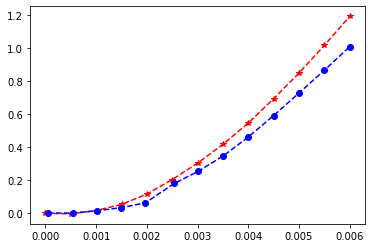

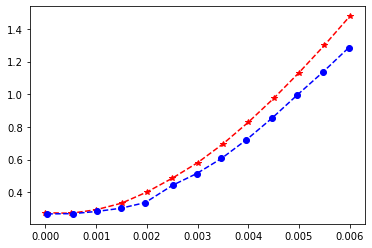

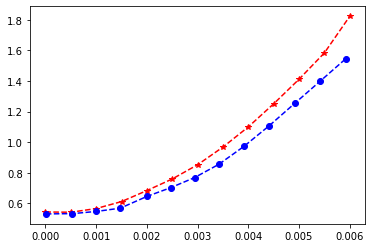

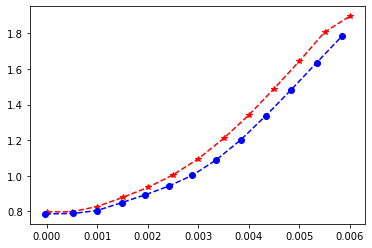

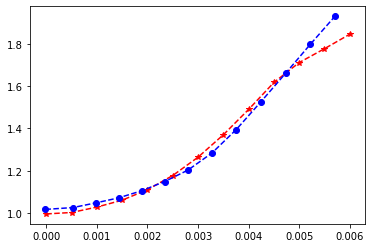

In [87]:
import numpy as np
import os
from matplotlib import pyplot as plt
from processing import *
from bezier_foil import *

parent = '/home/james/Documents/research/completed_cases/plenum_comparison/'

meanflow = 32.4074
c = 0.3
b = 0.156
rho = 1.17

QS = 0.5 * meanflow ** 2 * rho * c * b
aoas = np.arange(0,10.1,2.5)
mdots = np.arange(0,0.0061,0.0005)
M = len(aoas)
N = len(mdots)

lifts = np.zeros([M,N,2])
drags = np.zeros([M,N,2])
CL = np.zeros([M,N,2])
CD = np.zeros([M,N,2])
mdotspl = np.zeros(N)
cmupl = np.zeros(N)
cmusi = np.zeros(N)
for i in range(M):
    aoa = aoas[i]
    plt.figure()
    alpha = aoa * np.pi / 180
    for j in range(N):
        target_pl = parent + '/plenum/aoa{}_mdot{}/'.format(aoas[i],round(mdots[j],4))
        F,M,tt = retrieve_lift(target_pl)
        vjetpl = max_velocity(target_pl)
        lifts[i,j,1] = F[-1,1] * np.cos(alpha) - F[-1,0] * np.sin(alpha)
        drags[i,j,1] = F[-1,0] * np.cos(alpha) + F[-1,1] * np.sin(alpha)
        
        mdotspl[j] = massflow_bc(target_pl)
        cmupl[j] = mdotspl[j]*vjetpl / QS
        target_si = parent + '/simple/aoa{}_mdot{}/'.format(aoas[i],round(mdots[j],4))
        F,M,tt = retrieve_lift(target_si)
        vjet = max_velocity(target_si)
        cmusi[j] = mdot[j]*vjetpl / QS
        lifts[i,j,0] = F[-1,1] * np.cos(alpha) - (F[-1,0]-mdot[j]*vjet) * np.sin(alpha)
        drags[i,j,0] = (F[-1,0]-mdot[j]*vjet) * np.cos(alpha) + F[-1,1] * np.sin(alpha)
        
        CL[i,j,:] = lifts[i,j,:] / QS
        CD[i,j,:] = drags[i,j,:] / QS
        
    plt.plot(mdots,CL[i,:,0],'r*--',mdotspl,CL[i,:,1],'bo--')
    
    
    

        

CD = drags / QS
        
        

